In [1]:
import sys
import os

if 'google.colab' in sys.modules:
    prev_dir = os.getcwd()

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Replace with correct location
    %cd /content/drive/MyDrive/Colab Notebooks/DiffusionOfExperts

    !pip install accelerate datasets transformers wandb peft diffusers

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DiffusionOfExperts
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.4 MB/s eta 0:00:00
  Using cached

In [2]:
# To make our imports work because python relative imports suck
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

In [3]:
import argparse
import logging
import math
import random
import shutil
from contextlib import nullcontext
from pathlib import Path
from dataclasses import dataclass
from typing import List

import datasets
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset, load_from_disk, concatenate_datasets
from huggingface_hub import create_repo, upload_folder
from packaging import version
from peft import LoraConfig
from peft.utils import get_peft_model_state_dict
from torchvision import transforms
from tqdm import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from textwrap import wrap
import matplotlib.pyplot as plt

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import cast_training_params, compute_snr
from diffusers.utils import check_min_version, convert_state_dict_to_diffusers, is_wandb_available
from diffusers.utils.hub_utils import load_or_create_model_card, populate_model_card
from diffusers.utils.import_utils import is_xformers_available
from diffusers.utils.torch_utils import is_compiled_module

In [4]:
@dataclass
class Config:
    pretrained_model_name_or_path: str = "CompVis/stable-diffusion-v1-4"
    datasets = ["clothes_dataset", "pixelart_dataset", "photograph_dataset"]
    learning_rate: float = 1e-05
    max_train_samples: int = 1000
    num_train_epochs: int = 20
    checkpointing_steps: int = 2000
    train_batch_size: int = 2
    resume_from_checkpoint: str = "latest"
    output_dir: str = "./model_downloads/mlp_blended"
    gradient_accumulation_steps: int = 1
    # This can be set to 'no', 'fp16', 'bf16' based on system config
    mixed_precision: str = None
    report_to: str = "wandb"
    seed: int = 42

    # New fields with their argparse defaults
    revision: str = None
    variant: str = None
    dataset_config_name: str = None
    train_data_dir: str = None
    image_column: str = "image"
    caption_column: str = "text"
    validation_prompt: str = None
    num_validation_images: int = 4
    validation_epochs: int = 1
    cache_dir: str = None
    resolution: int = 512
    center_crop: bool = False
    random_flip: bool = False
    max_train_steps: int = None
    scale_lr: bool = False
    lr_scheduler: str = "constant"
    lr_warmup_steps: int = 500
    snr_gamma: float = None
    use_8bit_adam: bool = False
    allow_tf32: bool = False
    dataloader_num_workers: int = 0
    adam_beta1: float = 0.9
    adam_beta2: float = 0.999
    adam_weight_decay: float = 1e-2
    adam_epsilon: float = 1e-08
    max_grad_norm: float = 1.0
    push_to_hub: bool = False
    hub_token: str = None
    prediction_type: str = None
    hub_model_id: str = None
    logging_dir: str = "logs"
    local_rank: int = -1
    checkpoints_total_limit: int = None
    enable_xformers_memory_efficient_attention: bool = False
    noise_offset: float = 0
    rank: int = 4
    gradient_checkpointing: bool = False


CONFIG = Config()

In [5]:
if CONFIG.report_to == "wandb":
    if not is_wandb_available():
        raise ImportError(
            "Make sure to install wandb if you want to use it for logging during training.")

    import wandb

# If passed along, set the training seed now.
if CONFIG.seed is not None:
    set_seed(CONFIG.seed)

In [6]:
accelerator_project_config = ProjectConfiguration(
    project_dir=CONFIG.output_dir,
    logging_dir=CONFIG.output_dir
)

accelerator = Accelerator(
    # gradient_accumulation_steps=CONFIG.gradient_accumulation_steps,
    # mixed_precision=CONFIG.mixed_precision,
    log_with=CONFIG.report_to,
    project_config=accelerator_project_config,
)

# Disable AMP for MPS.
if torch.backends.mps.is_available():
    accelerator.native_amp = False

# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

logger = get_logger(__name__, log_level="INFO")
logger.info(accelerator.state, main_process_only=False)

if accelerator.is_local_main_process:
    datasets.utils.logging.set_verbosity_warning()
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    datasets.utils.logging.set_verbosity_error()
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()


# Handle the repository creation
if accelerator.is_main_process:
    if CONFIG.output_dir is not None:
        os.makedirs(CONFIG.output_dir, exist_ok=True)

    # We are not pushing our model to HuggingFace Hub
    # if CONFIG.push_to_hub:
    #     repo_id = create_repo(
    #         repo_id=CONFIG.hub_model_id or Path(CONFIG.output_dir).name,
    #         exist_ok=True,
    #         token=CONFIG.hub_token
    #     ).repo_id

INFO:__main__:Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no



### Load noise scheduler, tokenizer, and models.


In [7]:
import os
import torch
from torch import nn
from diffusers.loaders import LoraLoaderMixin
from models.StableDiffusion import StableDiffusion

class GatedMoELayer(nn.Module):
    def __init__(self, channels, num_experts):
        super(GatedMoELayer, self).__init__()
        self.num_experts = num_experts

        # One gate and associated prompt-guidance per unet

        self.gates = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(channels, channels*2, 9), # Go from `(batch_size, 4, 64, 64)` to `(batch_size, 16, 56, 56)`
                nn.SiLU(),
                nn.Conv2d(channels*2, channels*2, 9), # Go from `(batch_size, 16, 56, 56)` to `(batch_size, 4, 48, 48)`
                nn.SiLU(),
                nn.Conv2d(channels*2, channels, 9), # Go from `(batch_size, 16, 48, 48)` to `(batch_size, 4, 40, 40)`
                nn.SiLU(),
                nn.Flatten()
            ) for _ in range(self.num_experts)
        ])

        self.prompt_mapping = nn.ModuleList([
            nn.Sequential(
                # Input is: Output of conv gate + flattened prompt embeddings
                nn.Linear((channels*40*40) + (77*768), 1024),
                nn.ReLU(),
                nn.Linear(1024, 256),
                nn.ReLU(),
                nn.Linear(256, 256),
                nn.ReLU(),
                nn.Linear(256, 1)
            ) for _ in range(self.num_experts)
        ])

    def forward(self, latent_unets, encoded_prompt):
        latent_shape = latent_unets[0].shape

        flat_prompt = encoded_prompt.view(encoded_prompt.shape[0], -1)
        gate_outputs = [
            # Pass the noise through each prompt-guided gate. Each one has output shape `(batch_size, 1)`
            self.prompt_mapping[i](torch.cat((self.gates[i](noise), flat_prompt), dim=1))
            for i, noise in enumerate(latent_unets)
        ]
        gate_outputs = torch.stack((*gate_outputs, ), dim=1) # shape: `(batch_size, n_experts, 1)`
        gate_outputs = F.softmax(gate_outputs, dim=1) # Softmax across experts per example

        # Each UNet is its own expert.
        latent_unets = torch.stack((*latent_unets, ), dim=1)
        # After stacking, the UNet weights have shape (batch_size, n_experts, 4, 64, 64)
        # So, we flatten them here so we can multiply by each gate. New shape: (batch_size, n_experts, 4*64*64)
        latent_unets = latent_unets.view((latent_shape[0], self.num_experts, -1))

        # Combine the gated experts and reshape back to latent shape
        predicted_noise = torch.einsum('bij,bik->bk', gate_outputs, latent_unets)
        predicted_noise = predicted_noise.view(latent_shape)

        # Output shape (batch_size, 4, 64, 64). So, all UNets are combined by experts.
        return predicted_noise, gate_outputs


class MLPBlendedUNet(StableDiffusion):
    def __init__(self, model_path: str, lora_paths: list[str]):
        super().__init__(model_path)

        # Freeze parameters of models to save more memory
        self.text_encoder.requires_grad_(False)
        self.vae.requires_grad_(False)

        # Load the default UNets
        self.unets = nn.ModuleList([
            UNet2DConditionModel.from_pretrained(
                CONFIG.pretrained_model_name_or_path,
                subfolder="unet",
                revision=CONFIG.revision,
                variant=CONFIG.variant
            )

            for _ in lora_paths
        ])

        self.num_channels_latents: int = self.unet.config.in_channels
        self.unet = None  # let it be garbage collected since we don't need the original unet any more
        # self.representative_embeddings = []

        # Apply lora weights to each UNet
        for u, lora_path in zip(self.unets, lora_paths):
            # load lora weights
            state_dict, network_alphas = LoraLoaderMixin.lora_state_dict(lora_path, weight_name='pytorch_lora_weights.safetensors')
            LoraLoaderMixin.load_lora_into_unet(state_dict, network_alphas=network_alphas, unet=u)

        # Freeze the unet parameters before adding adapters
        for idx, u in enumerate(self.unets):
            u.requires_grad_(False)

            for param in u.parameters():
                param.requires_grad_(False)

        self.moe_layer = GatedMoELayer(
            channels=4, # Match channels of latent space
            num_experts=3  # Learn a gate for each unet
        )

    def predict_moe_noise(self, latent_inputs: torch.Tensor, timesteps: int, encoded_prompt: torch.Tensor):
        unet_outputs = []

        for unet in self.unets:
            unet_output = unet(latent_inputs, timesteps, encoded_prompt, return_dict=False)[0]
            unet_outputs.append(unet_output)

        moe_output, gates = self.moe_layer(unet_outputs, encoded_prompt)

        # perform guidance
        noise_pred_uncond, noise_pred_text = moe_output.chunk(2)
        noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

        return noise_pred, gates

    def forward(self, prompt: str | list[str], num_inference_steps: int = 100, expert: int = None):
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        encoded_prompt = self.encode_prompt(prompt)

        self.scheduler.set_timesteps(num_inference_steps)
        timesteps = self.scheduler.timesteps

        latents = self.prepare_latents(
            batch_size,
            self.num_channels_latents,
        )

        # start denoising process
        for t in tqdm(timesteps):
            latent_model_input = torch.cat([latents] * 2) # double the latents since we have the unconditional text prompt too
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # Predict the noise
            if expert is None:
                noise_pred, _ = self.predict_moe_noise(latent_model_input, t, encoded_prompt)
            else:
                noise_pred = self.unets[expert](latent_model_input, t, encoded_prompt)[0]
                # perform guidance
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

        # decode the latent space to get generated image
        image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
        image = self.image_processor.postprocess(image, output_type='pil', do_denormalize=([True] * image.shape[0]))

        return image

In [8]:
noise_scheduler: DDPMScheduler = DDPMScheduler.from_pretrained(
    CONFIG.pretrained_model_name_or_path,
    subfolder="scheduler"
)

tokenizer: CLIPTokenizer = CLIPTokenizer.from_pretrained(
    CONFIG.pretrained_model_name_or_path,
    subfolder="tokenizer",
    revision=CONFIG.revision
)

# The blended UNet
blended_unet = MLPBlendedUNet(
    model_path="CompVis/stable-diffusion-v1-4",
    lora_paths=[
        './model_downloads/clothes_finetuned_model',
        './model_downloads/pixelart_finetuned_model',
        './model_downloads/photograph_finetuned_model'
    ]
)

# For mixed precision training we cast all non-trainable weights (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
weight_dtype = torch.float32

# Move unet, vae and text_encoder to device and cast to weight_dtype
blended_unet = blended_unet.to(accelerator.device, dtype=weight_dtype)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

{'prediction_type', 'timestep_spacing', 'dynamic_thresholding_ratio', 'rescale_betas_zero_snr', 'clip_sample_range', 'variance_type', 'sample_max_value', 'thresholding'} was not found in config. Values will be initialized to default values.


tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

{'prediction_type', 'timestep_spacing', 'dynamic_thresholding_ratio', 'rescale_betas_zero_snr', 'clip_sample_range', 'variance_type', 'sample_max_value', 'thresholding'} was not found in config. Values will be initialized to default values.


text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

{'force_upcast', 'norm_num_groups', 'latents_mean', 'latents_std'} was not found in config. Values will be initialized to default values.


unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

{'resnet_time_scale_shift', 'resnet_skip_time_act', 'projection_class_embeddings_input_dim', 'timestep_post_act', 'addition_time_embed_dim', 'mid_block_type', 'time_cond_proj_dim', 'upcast_attention', 'addition_embed_type', 'num_attention_heads', 'num_class_embeds', 'class_embeddings_concat', 'use_linear_projection', 'encoder_hid_dim', 'time_embedding_act_fn', 'dual_cross_attention', 'attention_type', 'dropout', 'reverse_transformer_layers_per_block', 'addition_embed_type_num_heads', 'encoder_hid_dim_type', 'time_embedding_dim', 'transformer_layers_per_block', 'resnet_out_scale_factor', 'class_embed_type', 'conv_out_kernel', 'only_cross_attention', 'time_embedding_type', 'cross_attention_norm', 'conv_in_kernel', 'mid_block_only_cross_attention'} was not found in config. Values will be initialized to default values.
{'resnet_time_scale_shift', 'resnet_skip_time_act', 'projection_class_embeddings_input_dim', 'timestep_post_act', 'addition_time_embed_dim', 'mid_block_type', 'time_cond_pro

In [9]:
# Enable TF32 for faster training on Ampere GPUs,
# cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
if CONFIG.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True

if CONFIG.scale_lr:
    CONFIG.learning_rate = (
        CONFIG.learning_rate * CONFIG.gradient_accumulation_steps *
        CONFIG.train_batch_size * accelerator.num_processes
    )

### Optimizer


In [10]:
lora_layers = filter(lambda p: p.requires_grad, blended_unet.parameters())

optimizer = torch.optim.AdamW(
    lora_layers,
    lr=CONFIG.learning_rate,
    betas=(CONFIG.adam_beta1, CONFIG.adam_beta2),
    weight_decay=CONFIG.adam_weight_decay,
    eps=CONFIG.adam_epsilon,
)

In [11]:
for name, parameter in blended_unet.named_parameters(): # with train_lora=True
    if parameter.requires_grad:
        print(name)

moe_layer.gates.0.0.weight
moe_layer.gates.0.0.bias
moe_layer.gates.0.2.weight
moe_layer.gates.0.2.bias
moe_layer.gates.0.4.weight
moe_layer.gates.0.4.bias
moe_layer.gates.1.0.weight
moe_layer.gates.1.0.bias
moe_layer.gates.1.2.weight
moe_layer.gates.1.2.bias
moe_layer.gates.1.4.weight
moe_layer.gates.1.4.bias
moe_layer.gates.2.0.weight
moe_layer.gates.2.0.bias
moe_layer.gates.2.2.weight
moe_layer.gates.2.2.bias
moe_layer.gates.2.4.weight
moe_layer.gates.2.4.bias
moe_layer.prompt_mapping.0.0.weight
moe_layer.prompt_mapping.0.0.bias
moe_layer.prompt_mapping.0.2.weight
moe_layer.prompt_mapping.0.2.bias
moe_layer.prompt_mapping.0.4.weight
moe_layer.prompt_mapping.0.4.bias
moe_layer.prompt_mapping.0.6.weight
moe_layer.prompt_mapping.0.6.bias
moe_layer.prompt_mapping.1.0.weight
moe_layer.prompt_mapping.1.0.bias
moe_layer.prompt_mapping.1.2.weight
moe_layer.prompt_mapping.1.2.bias
moe_layer.prompt_mapping.1.4.weight
moe_layer.prompt_mapping.1.4.bias
moe_layer.prompt_mapping.1.6.weight
moe_la

### Dataset


In [12]:
dataset1 = {'train': load_from_disk(CONFIG.datasets[0])}
dataset2 = {'train': load_from_disk(CONFIG.datasets[1])}
dataset3 = {'train': load_from_disk(CONFIG.datasets[2])}

# Placeholder. Will be populated will all datasets later.
dataset = { "train": dataset1['train'] }

column_names = dataset["train"].column_names

In [13]:
# DATASET_NAME_MAPPING = {
#     "lambdalabs/pokemon-blip-captions": ("image", "text"),
# }

# # 6. Get the column names for input/target.
# # TODO: ALL DATASETS NEED TO BE LOADED
# dataset_columns = DATASET_NAME_MAPPING.get(CONFIG.datasets[0], None)

image_column = CONFIG.image_column
caption_column = CONFIG.caption_column

In [14]:
# Preprocessing the datasets.
# We need to tokenize input captions and transform the images.
def tokenize_captions(examples, is_train=True):
    captions = []
    for caption in examples[caption_column]:
        if isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])
        else:
            raise ValueError(
                f"Caption column `{caption_column}` should contain either strings or lists of strings."
            )
    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )

    return inputs.input_ids


# Preprocessing the datasets.
train_transforms = transforms.Compose(
    [
        transforms.Resize(CONFIG.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(CONFIG.resolution) if CONFIG.center_crop else transforms.RandomCrop(CONFIG.resolution),
        transforms.RandomHorizontalFlip() if CONFIG.random_flip else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [15]:
def unwrap_model(model):
    model = accelerator.unwrap_model(model)
    model = model._orig_mod if is_compiled_module(model) else model
    return model

def preprocess_train(examples):
    images = [image.convert("RGB") for image in examples[image_column]]
    examples["pixel_values"] = [train_transforms(image) for image in images]
    # examples["input_ids"] = tokenize_captions(examples)
    examples["text"] = examples["text"]
    return examples

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    # text = torch.stack([example["text"] for example in examples])
    return {"pixel_values": pixel_values, "text": [example["text"] for example in examples]}

In [16]:
with accelerator.main_process_first():
    if CONFIG.max_train_samples is not None:
        # WE ALSO CHANGE THIS FROM ORIGINAL:
        # dataset["train"] = dataset["train"].shuffle(seed=CONFIG.seed).select(range(CONFIG.max_train_samples))
        dataset["train"] = concatenate_datasets([
            dataset1['train'].select(range(1000, 1000+CONFIG.max_train_samples)),
            dataset2['train'].select(range(1000, 1000+CONFIG.max_train_samples)),
            dataset3['train'].select(range(1000, 1000+CONFIG.max_train_samples))
        ]).shuffle(seed=CONFIG.seed)

    # Set the training transforms
    train_dataset = dataset["train"].with_transform(preprocess_train)

# DataLoaders creation:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=CONFIG.train_batch_size,
    num_workers=CONFIG.dataloader_num_workers,
)

In [17]:
# Scheduler and math around the number of training steps.
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / CONFIG.gradient_accumulation_steps)

if CONFIG.max_train_steps is None:
    CONFIG.max_train_steps = CONFIG.num_train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True

lr_scheduler = get_scheduler(
    CONFIG.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=CONFIG.lr_warmup_steps * accelerator.num_processes,
    num_training_steps=CONFIG.max_train_steps * accelerator.num_processes,
)

In [18]:
# Prepare everything with our `accelerator`.
blended_unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    blended_unet, optimizer, train_dataloader, lr_scheduler
)

# We need to recalculate our total training steps as the size of the training dataloader may have changed.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / CONFIG.gradient_accumulation_steps)

if overrode_max_train_steps:
    CONFIG.max_train_steps = CONFIG.num_train_epochs * num_update_steps_per_epoch

# Afterwards we recalculate our number of training epochs
CONFIG.num_train_epochs = math.ceil(
    CONFIG.max_train_steps / num_update_steps_per_epoch)

# We need to initialize the trackers we use, and also store our configuration.
# The trackers initializes automatically on the main process.
if accelerator.is_main_process:
    accelerator.init_trackers("text2image-fine-tune", config=vars(CONFIG))

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [19]:
def plot_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))

    for ax, img, prompt in zip(axs, images, prompts):
        img = transforms.ToTensor()(img)
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title('\n'.join(wrap(prompt, 50)), fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


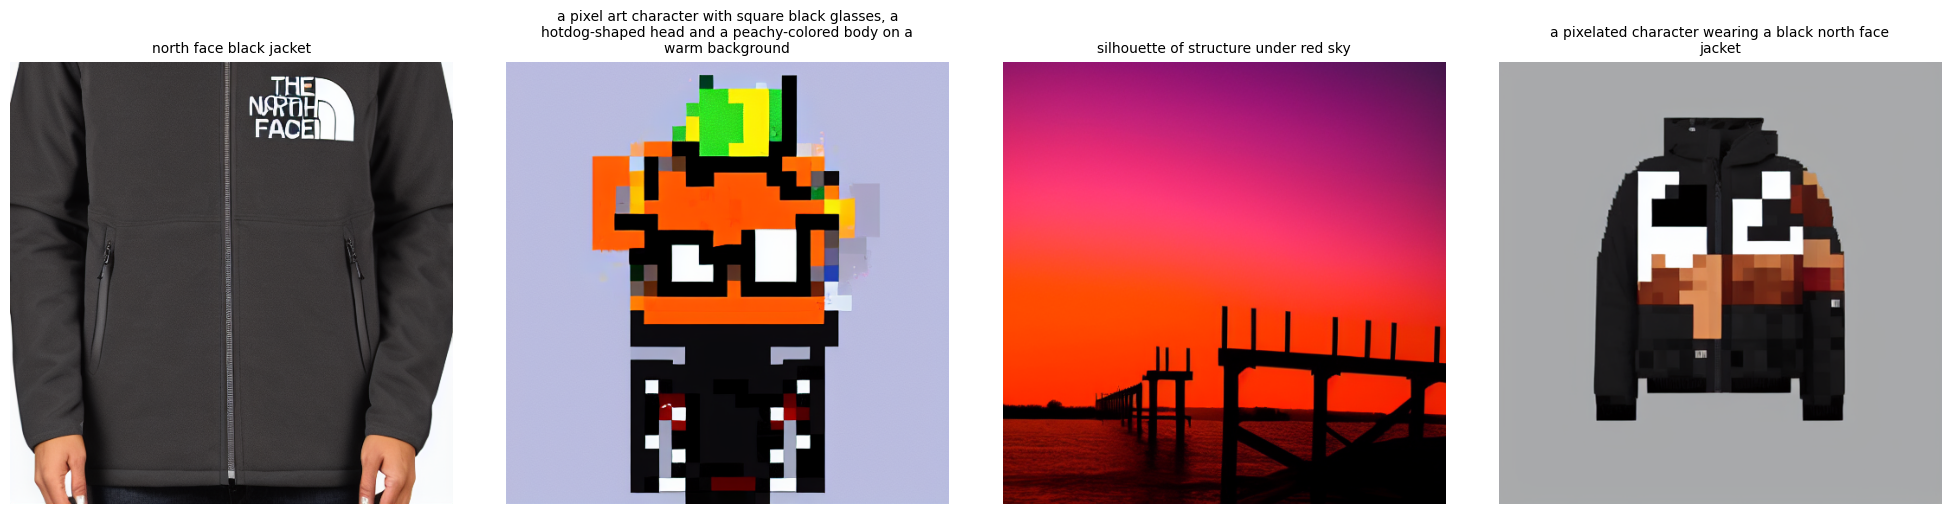

In [20]:
blended_unet.eval()

prompts = [
    'north face black jacket',
    'a pixel art character with square black glasses, a hotdog-shaped head and a peachy-colored body on a warm background',
    'silhouette of structure under red sky',
    'a pixelated character wearing a black north face jacket',
]

with torch.no_grad():
    images = blended_unet(prompts)

plot_images(images)

### Training


In [21]:
total_batch_size = CONFIG.train_batch_size * accelerator.num_processes * CONFIG.gradient_accumulation_steps

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num Epochs = {CONFIG.num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {CONFIG.train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {CONFIG.gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {CONFIG.max_train_steps}")
global_step = 0
first_epoch = 0

# initialize variables for keeping track of this expert's representative embedding
total_embedding = 0
num_samples = 0

# Potentially load in the weights and states from a previous save
if CONFIG.resume_from_checkpoint:
    if CONFIG.resume_from_checkpoint != "latest":
        path = os.path.basename(CONFIG.resume_from_checkpoint)
    else:
        # Get the most recent checkpoint
        dirs = os.listdir(CONFIG.output_dir)
        dirs = [d for d in dirs if d.startswith("checkpoint")]
        dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
        path = dirs[-1] if len(dirs) > 0 else None

    if path is None:
        accelerator.print(
            f"Checkpoint '{CONFIG.resume_from_checkpoint}' does not exist. Starting a new training run."
        )
        CONFIG.resume_from_checkpoint = None
        initial_global_step = 0
    else:
        accelerator.print(f"Resuming from checkpoint {path}")
        accelerator.load_state(os.path.join(CONFIG.output_dir, path))
        global_step = int(path.split("-")[1])
        checkpoint_representative_embedding = torch.load(os.path.join(CONFIG.output_dir, path, 'representative_embedding.pt'))
        num_samples = global_step
        # checkpoint_representative_embedding starts out as an average
        total_embedding = checkpoint_representative_embedding * num_samples

        initial_global_step = global_step
        first_epoch = global_step // num_update_steps_per_epoch
else:
    initial_global_step = 0

progress_bar = tqdm(
    range(0, CONFIG.max_train_steps),
    initial=initial_global_step,
    desc="Steps",
    # Only show the progress bar once on each machine.
    disable=not accelerator.is_local_main_process,
)

INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 3000
INFO:__main__:  Num Epochs = 20
INFO:__main__:  Instantaneous batch size per device = 2
INFO:__main__:  Total train batch size (w. parallel, distributed & accumulation) = 2
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 30000


Checkpoint 'latest' does not exist. Starting a new training run.


Steps:   0%|          | 0/30000 [00:00<?, ?it/s]

In [22]:
for name, parameter in blended_unet.named_parameters():
    if parameter.requires_grad:
        print(name)

moe_layer.gates.0.0.weight
moe_layer.gates.0.0.bias
moe_layer.gates.0.2.weight
moe_layer.gates.0.2.bias
moe_layer.gates.0.4.weight
moe_layer.gates.0.4.bias
moe_layer.gates.1.0.weight
moe_layer.gates.1.0.bias
moe_layer.gates.1.2.weight
moe_layer.gates.1.2.bias
moe_layer.gates.1.4.weight
moe_layer.gates.1.4.bias
moe_layer.gates.2.0.weight
moe_layer.gates.2.0.bias
moe_layer.gates.2.2.weight
moe_layer.gates.2.2.bias
moe_layer.gates.2.4.weight
moe_layer.gates.2.4.bias
moe_layer.prompt_mapping.0.0.weight
moe_layer.prompt_mapping.0.0.bias
moe_layer.prompt_mapping.0.2.weight
moe_layer.prompt_mapping.0.2.bias
moe_layer.prompt_mapping.0.4.weight
moe_layer.prompt_mapping.0.4.bias
moe_layer.prompt_mapping.0.6.weight
moe_layer.prompt_mapping.0.6.bias
moe_layer.prompt_mapping.1.0.weight
moe_layer.prompt_mapping.1.0.bias
moe_layer.prompt_mapping.1.2.weight
moe_layer.prompt_mapping.1.2.bias
moe_layer.prompt_mapping.1.4.weight
moe_layer.prompt_mapping.1.4.bias
moe_layer.prompt_mapping.1.6.weight
moe_la

In [ ]:
for epoch in range(first_epoch, CONFIG.num_train_epochs):
    blended_unet.train()
    train_loss = 0.0

    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(blended_unet):
            # Convert images to latent space
            latents = blended_unet.vae.encode(batch["pixel_values"].to(dtype=weight_dtype))
            latents = latents.latent_dist.sample()
            latents = latents * blended_unet.vae.config.scaling_factor

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            if CONFIG.noise_offset:
                # https://www.crosslabs.org//blog/diffusion-with-offset-noise
                noise += CONFIG.noise_offset * torch.randn((latents.shape[0], latents.shape[1], 1, 1), device=latents.device)

            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning
            encoder_hidden_states = blended_unet.encode_prompt(batch["text"])

            # representative embedding for this expert stable diffusor
            # batch_embedding = encoder_hidden_states.mean(dim=1)  # Average over sequence length
            # total_embedding += batch_embedding
            # num_samples += batch_embedding.shape[0]

            # Get the target for loss depending on the prediction type
            if CONFIG.prediction_type is not None:
                # set prediction_type of scheduler if defined
                noise_scheduler.register_to_config(prediction_type=CONFIG.prediction_type)

            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            # Predict the noise residual and compute loss
            model_pred, learned_gates = blended_unet.predict_moe_noise(
                latent_inputs=torch.cat([noisy_latents] * 2), # double the latents since we have the unconditional text prompt too
                timesteps=torch.cat([timesteps] * 2), # double the latents since we have the unconditional text prompt too
                encoded_prompt=encoder_hidden_states
            )

            if CONFIG.snr_gamma is None:
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
            else:
                # Compute loss-weights as per Section 3.4 of https://arxiv.org/abs/2303.09556.
                # Since we predict the noise instead of x_0, the original formulation is slightly changed.
                # This is discussed in Section 4.2 of the same paper.
                snr = compute_snr(noise_scheduler, timesteps)
                mse_loss_weights = torch.stack([snr, CONFIG.snr_gamma * torch.ones_like(timesteps)], dim=1).min(dim=1)[0]
                if noise_scheduler.config.prediction_type == "epsilon":
                    mse_loss_weights = mse_loss_weights / snr
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    mse_loss_weights = mse_loss_weights / (snr + 1)

                loss = F.mse_loss(model_pred.float(), target.float(), reduction="none")
                loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                loss = loss.mean()

            # Gather the losses across all processes for logging (if we use distributed training).
            avg_loss = accelerator.gather(loss.repeat(CONFIG.train_batch_size)).mean()
            train_loss += avg_loss.item() / CONFIG.gradient_accumulation_steps

            # Backpropagate
            accelerator.backward(loss)
            if accelerator.sync_gradients:
                params_to_clip = lora_layers
                accelerator.clip_grad_norm_(params_to_clip, CONFIG.max_grad_norm)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # Checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1
            accelerator.log({"train_loss": train_loss}, step=global_step)
            train_loss = 0.0

            if global_step % CONFIG.checkpointing_steps == 0:
                if accelerator.is_main_process:
                    # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                    if CONFIG.checkpoints_total_limit is not None:
                        checkpoints = os.listdir(CONFIG.output_dir)
                        checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                        checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                        # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                        if len(checkpoints) >= CONFIG.checkpoints_total_limit:
                            num_to_remove = len(checkpoints) - CONFIG.checkpoints_total_limit + 1
                            removing_checkpoints = checkpoints[0:num_to_remove]

                            logger.info(f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints")
                            logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                            for removing_checkpoint in removing_checkpoints:
                                removing_checkpoint = os.path.join(CONFIG.output_dir, removing_checkpoint)
                                shutil.rmtree(removing_checkpoint)

                    save_path = os.path.join(CONFIG.output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)

                    # checkpoint_representative_embedding = total_embedding / num_samples
                    # torch.save(checkpoint_representative_embedding, os.path.join(save_path, 'representative_embedding.pt'))

                    # unwrapped_unet = unwrap_model(blended_unet)
                    # unet_lora_state_dict = convert_state_dict_to_diffusers(
                    #     get_peft_model_state_dict(unwrapped_unet)
                    # )

                    # StableDiffusionPipeline.save_lora_weights(
                    #     save_directory=save_path,
                    #     unet_lora_layers=unet_lora_state_dict,
                    #     safe_serialization=True,
                    # )

                    logger.info(f"Saved state to {save_path}")

        logs = {"step_loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)

        if global_step >= CONFIG.max_train_steps:
            break

    if accelerator.is_main_process:
        if CONFIG.validation_prompt is not None and epoch % CONFIG.validation_epochs == 0:
            logger.info(
                f"Running validation... \n Generating {CONFIG.num_validation_images} images with prompt:"
                f" {CONFIG.validation_prompt}."
            )
            # create pipeline
            pipeline = DiffusionPipeline.from_pretrained(
                CONFIG.pretrained_model_name_or_path,
                unet=unwrap_model(blended_unet),
                revision=CONFIG.revision,
                variant=CONFIG.variant,
                torch_dtype=weight_dtype,
            )
            pipeline = pipeline.to(accelerator.device)
            pipeline.set_progress_bar_config(disable=True)

            # run inference
            generator = torch.Generator(device=accelerator.device)
            if CONFIG.seed is not None:
                generator = generator.manual_seed(CONFIG.seed)
            images = []
            if torch.backends.mps.is_available():
                autocast_ctx = nullcontext()
            else:
                autocast_ctx = torch.autocast(accelerator.device.type)

            with autocast_ctx:
                for _ in range(CONFIG.num_validation_images):
                    images.append(
                        pipeline(CONFIG.validation_prompt, num_inference_steps=30, generator=generator).images[0]
                    )

            for tracker in accelerator.trackers:
                if tracker.name == "tensorboard":
                    np_images = np.stack([np.asarray(img) for img in images])
                    tracker.writer.add_images("validation", np_images, epoch, dataformats="NHWC")
                if tracker.name == "wandb":
                    tracker.log(
                        {
                            "validation": [
                                wandb.Image(
                                    image, caption=f"{i}: {CONFIG.validation_prompt}")
                                for i, image in enumerate(images)
                            ]
                        }
                    )

            del pipeline
            torch.cuda.empty_cache()

Steps:   5%|▌         | 1649/30000 [15:14<4:22:22,  1.80it/s, lr=1e-5, step_loss=0.038]

In [ ]:
batch["text"]

In [ ]:
# These are the learned gates computed for the last batch before interruption
learned_gates

In [ ]:
learned_gates.sum(dim=1)

In [ ]:
blended_unet.eval()

with torch.no_grad():
    images = blended_unet(prompts)

In [ ]:
plot_images(images)